## Show cases Testing with Concept Activation Vectors (TCAV) on Imagenet Dataset and GoogleNet model

In [ ]:
#pip install captum

In [3]:
import numpy as np
import os, glob
import random

import matplotlib.pyplot as plt

from PIL import Image

from scipy.stats import ttest_ind

# ..........torch imports............
import torch
import torchvision

from torch.utils.data import IterableDataset, DataLoader
from torchvision import transforms

#.... Captum imports..................
from captum.attr import LayerGradientXActivation, LayerIntegratedGradients

from captum.concept import TCAV
from captum.concept import Concept

from captum.concept._utils.data_iterator import dataset_to_dataloader, CustomIterableDataset
from captum.concept._utils.common import concepts_to_str


In [4]:
# Method to normalize an image to Imagenet mean and standard deviation
def transform(img):

    return transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
            ),
        ]
    )(img)


In [5]:
def get_tensor_from_filename(filename):
    img = Image.open(filename).convert("RGB")
    return transform(img)


def load_image_tensors(class_name, root_path='./concepts/', transform=True):
    path = os.path.join(root_path, class_name)
    filenames = glob.glob(path + '/*.jpg')

    tensors = []
    for filename in filenames:
        img = Image.open(filename).convert('RGB')
        tensors.append(transform(img) if transform else img)
    
    return tensors

In [6]:
def assemble_concept(name, id, concepts_path="./concepts/"):
    concept_path = os.path.join(concepts_path, name) + "/"
    dataset = CustomIterableDataset(get_tensor_from_filename, concept_path)
    concept_iter = dataset_to_dataloader(dataset)

    return Concept(id=id, name=name, data_iter=concept_iter)


In [35]:
def format_float(f):
    return float('{:.3f}'.format(f) if abs(f) >= 0.0005 else '{:.3e}'.format(f))


def plot_tcav_scores(experimental_sets, tcav_scores, transpose = False):
    fig, ax = plt.subplots(1, len(experimental_sets), figsize = (25, 7))

    barWidth = 1 / (len(experimental_sets[0]) + 1)

    for idx_es, concepts in enumerate(experimental_sets):
        concepts = experimental_sets[idx_es]
        concepts_key = concepts_to_str(concepts)

        if not transpose:

            pos = [np.arange(len(layers))]
            for i in range(1, len(concepts)):
                pos.append([(x + barWidth) for x in pos[i-1]])

            _ax = (ax[idx_es] if len(experimental_sets) > 1 else ax)
            for i in range(len(concepts)):
                val = [format_float(scores['sign_count'][i]) for layer, scores in tcav_scores[concepts_key].items()]
                _ax.bar(pos[i], val, width=barWidth, edgecolor='white', label=concepts[i].name)
                

            # Add xticks on the middle of the group bars
            _ax.set_xlabel('Set {}'.format(str(idx_es)), fontweight='bold', fontsize=16)
            _ax.set_xticks([r + 0.3 * barWidth for r in range(len(layers))])
            _ax.set_xticklabels(layers, fontsize=16)

            # Create legend & Show graphic
            _ax.legend(fontsize=16)

        else:
            barWidth = 1 / (len(layers) + 1)

            pos = [np.arange(len(concepts))]
            for i in range(1, len(layers)):
                pos.append([(x + barWidth) for x in pos[i-1]])

            _ax = (ax[idx_es] if len(experimental_sets) > 1 else ax)
            for i in range(len(layers)):
                val = [format_float(tcav_scores[concepts_key][layers[i]]['sign_count'][j]) for j in range(len(concepts))]
                _ax.bar(pos[i], val, width=barWidth, edgecolor='white', label=layers[i])

            # Add xticks on the middle of the group bars
            _ax.set_xlabel('Set {}'.format(str(idx_es)), fontweight='bold', fontsize=16)
            _ax.set_xticks([r + 2 * barWidth for r in range(len(concepts))])
            _ax.set_xticklabels([concepts[t].name for t in range(len(concepts))], fontsize=16)

            # Create legend & Show graphic
            _ax.legend(fontsize=16)

    plt.show()



## Defining GoogleNet Model

For this tutorial, we will load GoogleNet model and set in eval mode.

In [7]:
model = torchvision.models.googlenet(pretrained=True)
model = model.eval()

C:\Users\andre\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\andre\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
layers=['inception4c', 'inception4d', 'inception4e']

layers=['inception3a', 'inception3b','inception4a', 
        'inception4b', 'inception4c', 'inception4d', 
        'inception4e','inception5a', 'inception5b']

mytcav = TCAV(model=model,
              layers=layers,
              layer_attr_method = LayerIntegratedGradients(
                model, None, multiply_by_inputs=False))


C:\Users\andre\anaconda3\lib\site-packages\captum\concept\_utils\classifier.py:130: UserWarning: Using default classifier for TCAV which keeps input both train and test datasets in the memory. Consider defining your own classifier that doesn't rely heavily on memory, for large number of concepts, by extending `Classifer` abstract class
  warnings.warn(


# Concept assembly

In [28]:
concepts_path = "./concepts"

stripes_concept = assemble_concept("striped", 0, concepts_path=concepts_path)
zigzagged_concept = assemble_concept("zigzagged", 1, concepts_path=concepts_path)
dotted_concept = assemble_concept("dotted", 2, concepts_path=concepts_path)
man_concept = assemble_concept("man", 3, concepts_path=concepts_path)
woman_concept = assemble_concept("woman", 4, concepts_path=concepts_path)
child_concept = assemble_concept("child", 5, concepts_path=concepts_path)


random_0_concept = assemble_concept("random500_0", 6, concepts_path=concepts_path)
random_1_concept = assemble_concept("random500_1", 7, concepts_path=concepts_path)

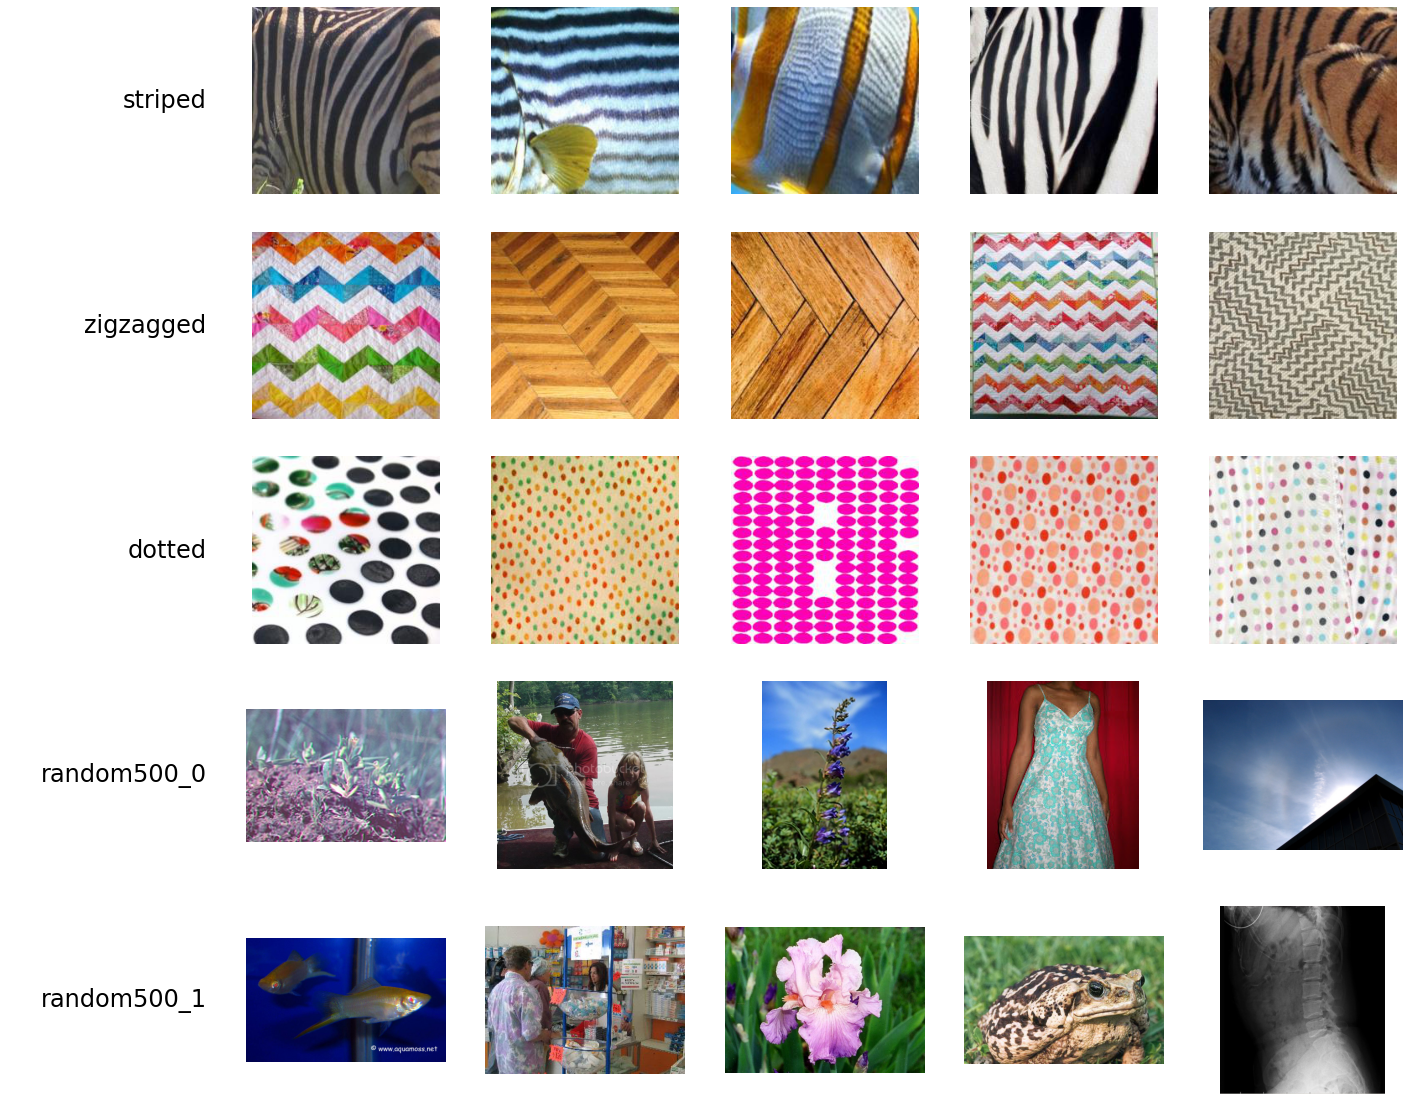

In [29]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
n_figs = 5
n_concepts = 5

fig, axs = plt.subplots(n_concepts, n_figs + 1, figsize = (25, 4 * n_concepts))

for c, concept in enumerate([stripes_concept, zigzagged_concept, dotted_concept, random_0_concept, random_1_concept]):
    concept_path = os.path.join(concepts_path, concept.name) + "/"
    img_files = glob.glob(concept_path + '*')
    for i, img_file in enumerate(img_files[:n_figs + 1]):
        if os.path.isfile(img_file):
            if i == 0:
                axs[c, i].text(1.0, 0.5, str(concept.name), ha='right', va='center', family='sans-serif', size=24)
            else:
                img = plt.imread(img_file)
                axs[c, i].imshow(img)

            axs[c, i].axis('off')

In [30]:
# Load sample images from folder
zebra_imgs = load_image_tensors('zebra',root_path=concepts_path, transform=False)
school_bus_imgs = load_image_tensors('school bus',root_path=concepts_path, transform=False)
salmon_imgs = load_image_tensors('salmon',root_path=concepts_path, transform=False)

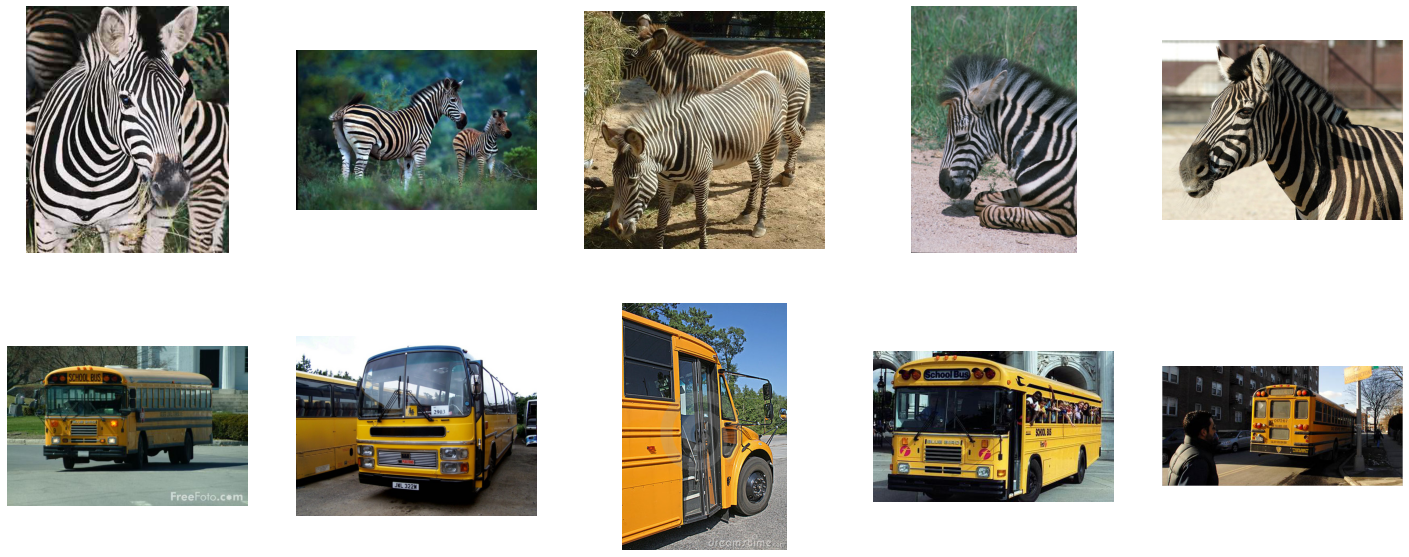

In [31]:
fig, axs = plt.subplots(2, 5, figsize = (25, 10))
for i in range(5):
    axs[0,i].imshow(zebra_imgs[random.randint(0,len(zebra_imgs))])
    axs[0,i].axis('off')
    axs[1,i].imshow(school_bus_imgs[random.randint(0,len(school_bus_imgs))])
    axs[1,i].axis('off')

plt.show()

In [32]:
# Load sample images from folder
zebra_tensors = torch.stack([transform(img) for img in zebra_imgs])
school_bus_tensors = torch.stack([transform(img) for img in school_bus_imgs])
salmon_tensors = torch.stack([transform(img) for img in salmon_imgs])

zebra_ind = 340
school_bus_ind = 779
salmon_ind = 391

# Zebra experiment >< Random

In [41]:
experimental_set_rand = [[stripes_concept, random_0_concept], [stripes_concept, random_1_concept]]

tcav_scores_w_random = mytcav.interpret(inputs=zebra_tensors,
                                        experimental_sets=experimental_set_rand,
                                        target=zebra_ind,
                                        n_steps=5,
                                       )
tcav_scores_w_random

defaultdict(<function captum.concept._core.tcav.TCAV.interpret.<locals>.<lambda>()>,
            {'0-6': defaultdict(None,
                         {'inception3a': {'sign_count': tensor([0.4933, 0.5067]),
                           'magnitude': tensor([ 0.0687, -0.0687])},
                          'inception3b': {'sign_count': tensor([0.7467, 0.2533]),
                           'magnitude': tensor([ 0.5975, -0.5975])},
                          'inception4a': {'sign_count': tensor([0.5867, 0.4133]),
                           'magnitude': tensor([ 0.3458, -0.3458])},
                          'inception4b': {'sign_count': tensor([0.4800, 0.5200]),
                           'magnitude': tensor([ 0.1731, -0.1731])},
                          'inception4c': {'sign_count': tensor([0.9600, 0.0400]),
                           'magnitude': tensor([ 0.7240, -0.7240])},
                          'inception4d': {'sign_count': tensor([1., 0.]),
                           'magnitude': tensor([

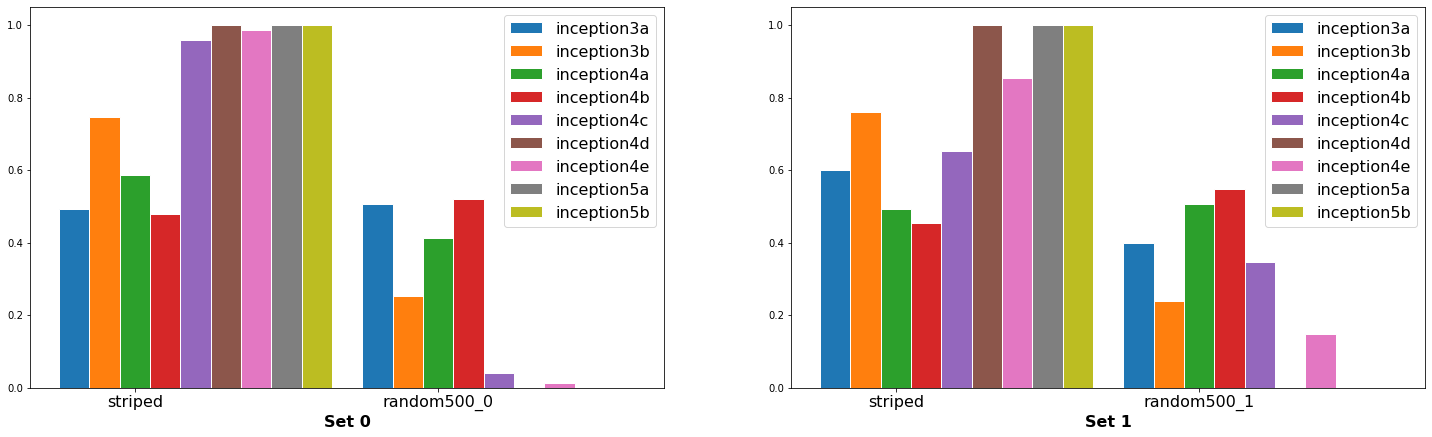

In [42]:
plot_tcav_scores(experimental_set_rand, tcav_scores_w_random, transpose=True)

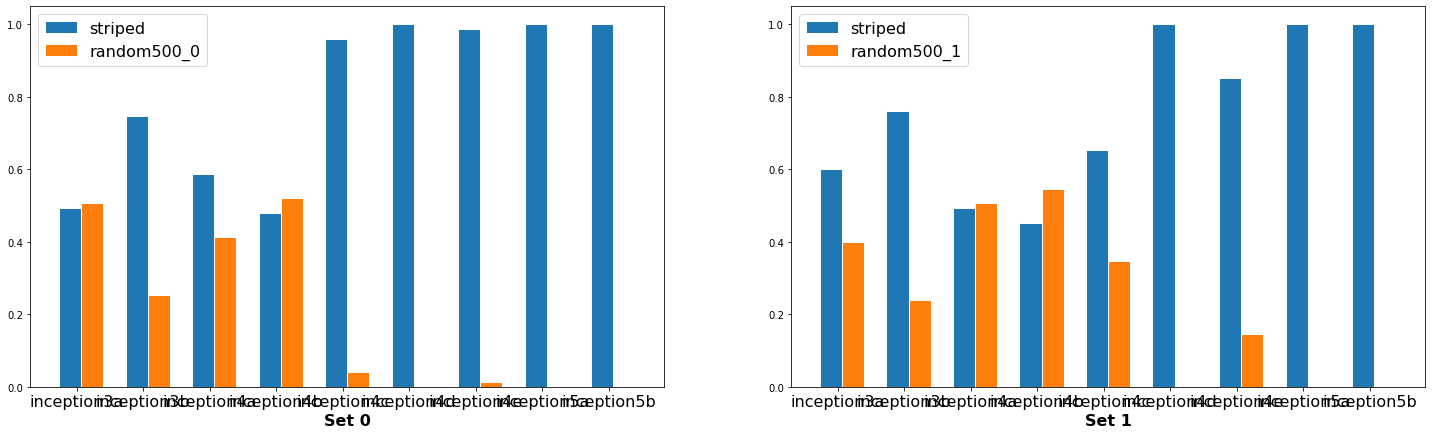

In [43]:
plot_tcav_scores(experimental_set_rand, tcav_scores_w_random, transpose=False)

# Zebra experiment >< Custom concepts

In [38]:
experimental_set_zig_dot = [[stripes_concept, zigzagged_concept, dotted_concept]]


tcav_scores_w_zig_dot = mytcav.interpret(inputs=zebra_tensors,
                                         experimental_sets=experimental_set_zig_dot,
                                         target=zebra_ind,
                                         n_steps=5)


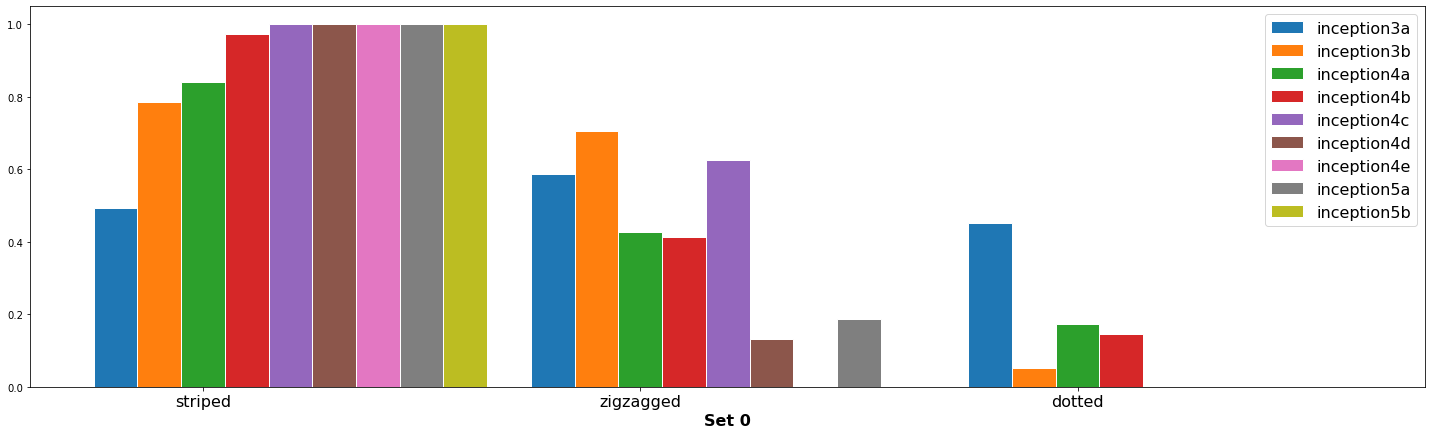

In [39]:
plot_tcav_scores(experimental_set_zig_dot, tcav_scores_w_zig_dot, transpose=True)

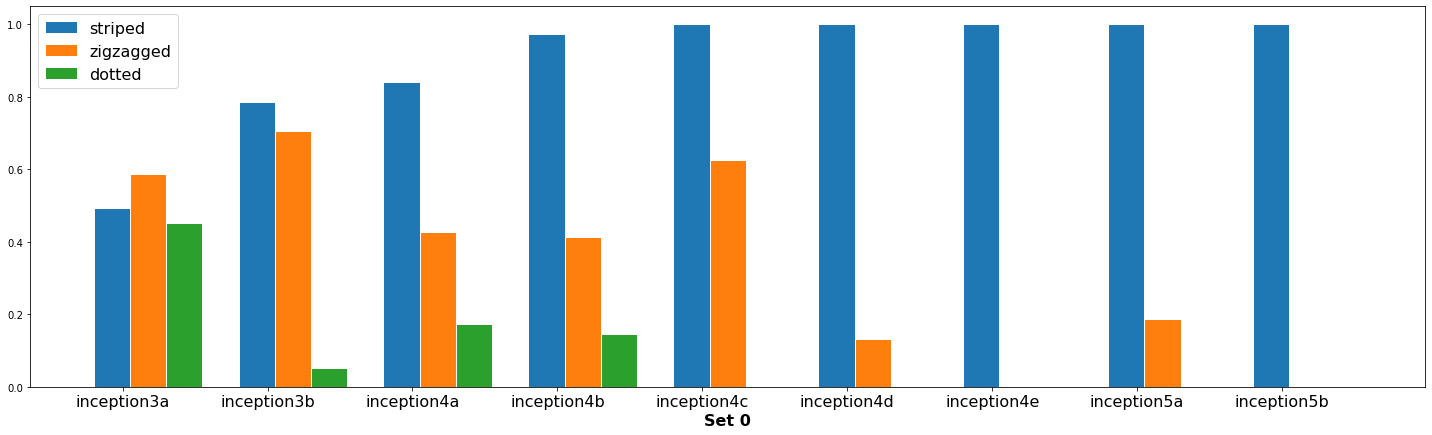

In [40]:
plot_tcav_scores(experimental_set_zig_dot, tcav_scores_w_zig_dot, transpose=False)

In [55]:
tcav_scores_w_zig_dot['0-1-2']['inception3a']['sign_count']

tensor([0.4933, 0.5867, 0.4533])

# School bus experiment >< custom concepts

In [33]:
experimental_set_school_bus = [[man_concept, woman_concept, child_concept]]


tcav_scores_w_school_bus = mytcav.interpret(inputs=school_bus_tensors,
                                         experimental_sets=experimental_set_school_bus,
                                         target=school_bus_ind,
                                         n_steps=5)


C:\Users\andre\anaconda3\lib\site-packages\captum\_utils\models\linear_model\train.py:351: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  bias_values = torch.FloatTensor([sklearn_model.intercept_]).to(  # type: ignore


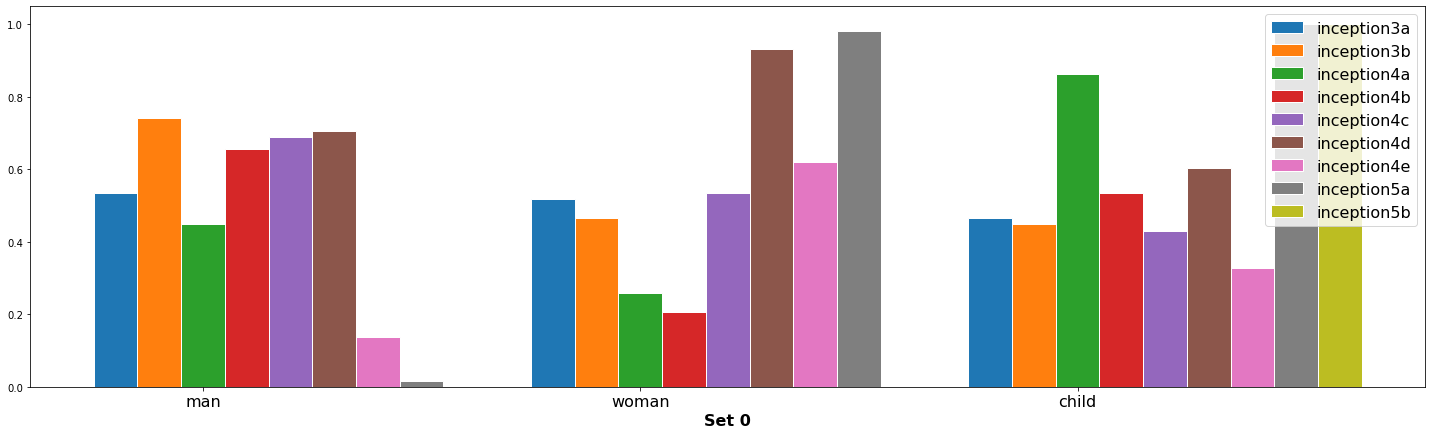

In [36]:
plot_tcav_scores(experimental_set_school_bus, tcav_scores_w_school_bus, transpose=True)

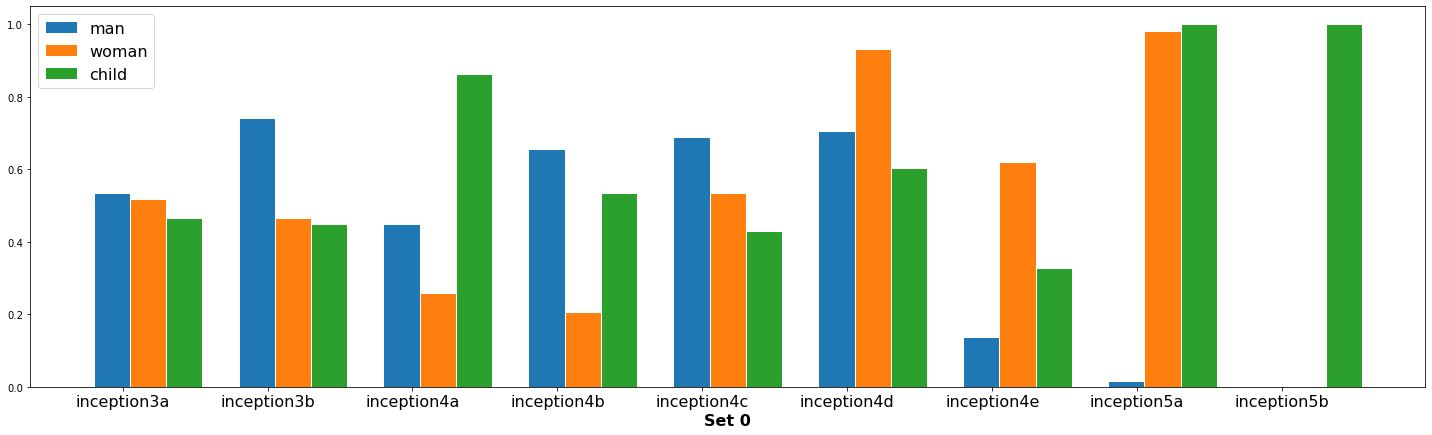

In [37]:
plot_tcav_scores(experimental_set_school_bus, tcav_scores_w_school_bus, transpose=False)